In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.metrics import accuracy_score

In [2]:
digits = load_digits()
dataset = [(digits.data[i][None, ...], digits.target[i]) for i in range(len(digits.target))]

In [3]:
train = dataset[:1700]
test = dataset[1700:]

In [4]:
np.random.seed(33)

INPUT_DIM = 64 # размер входного слоя
OUT_DIM = 10 # размер выходного слоя
H_DIM = 40 # размер скрытого слоя
LEARNING_RATE = 0.0001
NUM_EPOCHS = 50
BATCH_SIZE = 100 # размер батча
LAMBDA = 1e-4 # коэффициент регуляризации
GAMMA = 0.9 # коэффициент момента

def relu(t):
    return np.maximum(t, 0)

def softmax_batch(t):
    out = np.exp(t)
    return out / np.sum(out, axis=1, keepdims=True)

def sparse_cross_entropy_batch(z, y):
    return -np.log(np.array([z[j, y[j]] for j in range(len(y))]))

def to_full_batch(y, num_classes):
    y_full = np.zeros((len(y), num_classes))
    for j, yj in enumerate(y):
        y_full[j, yj] = 1
    return y_full

def relu_deriv(t):
    return (t >= 0).astype(float)

# инициализация весов с упором на функцию активации ReLU
W1 = np.random.normal(0.0, np.sqrt(2/INPUT_DIM),(INPUT_DIM, H_DIM))
b1 = np.random.normal(0.0, np.sqrt(2/1),(1, H_DIM))
W2 = np.random.normal(0.0, np.sqrt(2/H_DIM),(H_DIM, OUT_DIM))
b2 = np.random.normal(0.0, np.sqrt(2/1),(1, OUT_DIM))

# инициализация матрицы моментов
v_W1 = np.zeros_like(W1)
v_b1 = np.zeros_like(b1)
v_W2 = np.zeros_like(W2)
v_b2 = np.zeros_like(b2)

# массив с ошибками y-y_hat
loss_arr = []

for epoch in range(NUM_EPOCHS):
    for i in range(len(train) // BATCH_SIZE):
        batch_x, batch_y = zip(*dataset[i*BATCH_SIZE : i*BATCH_SIZE+BATCH_SIZE])
        x = np.concatenate(batch_x, axis=0)
        y = np.array(batch_y)

        # Forward
        t1 = x @ W1 + b1
        h1 = relu(t1)
        t2 = h1 @ W2 + b2
        z = softmax_batch(t2)
        E = np.sum(sparse_cross_entropy_batch(z, y))

        # Backward   
        y_full = to_full_batch(y, OUT_DIM)
        dE_dt2 = z - y_full
        dE_dW2 = h1.T @ dE_dt2 + 2 * LAMBDA * W2
        dE_db2 = np.sum(dE_dt2, axis=0, keepdims=True)
        dE_dh1 = dE_dt2 @ W2.T
        dE_dt1 = dE_dh1 * relu_deriv(t1)
        dE_dW1 = x.T @ dE_dt1 + 2 * LAMBDA * W1
        dE_db1 = np.sum(dE_dt1, axis=0, keepdims=True)
        
        # Обновление матрицы моментов
        v_W1 = GAMMA * v_W1 + LEARNING_RATE * dE_dW1
        v_b1 = GAMMA * v_b1 + LEARNING_RATE * dE_db1
        v_W2 = GAMMA * v_W2 + LEARNING_RATE * dE_dW2
        v_b2 = GAMMA * v_b2 + LEARNING_RATE * dE_db2

        # Обновление матрицы весов и векторов смещения
        W1 = W1 - v_W1
        b1 = b1 - v_b1
        W2 = W2 - v_W2
        b2 = b2 - v_b2
        
        loss_arr.append(E)

def predict(x):  
    t1 = x @ W1 + b1
    h1 = relu(t1)
    t2 = h1 @ W2 + b2
    z = softmax_batch(t2)
    return z

In [5]:
def calc_accuracy():
    y_pred = []
    y_true = []
    for x, y in test:
        z = predict(x)
        y_pred.append(np.argmax(z))
        y_true.append(y)
    return accuracy_score(y_true, y_pred)

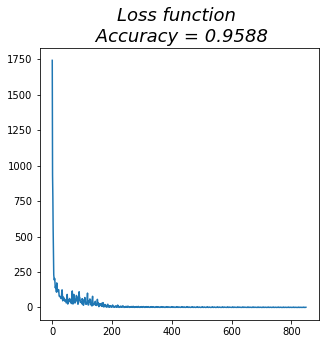

In [6]:
plt.figure(figsize=(5,5))

plt.title(f'Loss function \n Accuracy = {np.round(calc_accuracy(), 4)}', color='black', fontsize=18, fontstyle='italic')
plt.plot(loss_arr)
plt.show()